# Run the wake model for the inflow conditions (2023-08-24T17:00:00)

In [1]:
#from wakemodel import *
#from topdown import *
import copy
import numpy as np
import matplotlib.pyplot as plt
#from jensenmodel import JensenModel
import scipy.spatial as spt
import shapely.geometry as geom
import scipy.optimize as opt
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from netCDF4 import Dataset
#from coupledmodel import coupledmodel
import pandas as pd
import math
from sympy import symbols, Eq, solve
from floris import FlorisModel
from floris.turbine_library import build_cosine_loss_turbine_dict
from floris import  TimeSeries
from floris.flow_visualization import visualize_heterogeneous_cut_plane
from floris.layout_visualization import plot_turbine_labels
import pyproj 
from pyproj import Proj, Transformer
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import floris.layout_visualization as layoutviz
from floris import FlorisModel
from floris.flow_visualization import visualize_cut_plane

In [2]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})

In [3]:
from pathlib import Path

BASE_DIR = Path.cwd() 

# Intitalize the wind farms and inflow conditions.



Armadillo Flats

Turbine type AF1: 59 x GE 1.79 MW (100 m, 80 m)

Turbine type AF2: 21 x GE 1.715 MW (103 m, 80 m)

Turbine type AF3: 46 x GE 2.3 MW (116 m, 90 m)

King Plains

Turbine type KP: GE 2.82 MW (127 m, 89 m)

In [4]:
# Extract the layout data

file_path = BASE_DIR/'KingPlainsData/turbines_with_specs.csv'
turbine_df = pd.read_csv(file_path)


turbine_names_KP = turbine_df['# name'][0:88]
turbine_names_AF = turbine_df['# name'][89:]


#  turbine locations 
layout_x = turbine_df[' x'] 

 
layout_y = turbine_df[' y'] 


# Defining the model outcomes
plot_vel_field = True
use_calc_Cpp = True

# Inflow conditions
z0 = 0.15                                  # Bottom roughness height [m] based on LES paper
H = 1500                                   # Maximum height of the boundary layer [m]
rho = 1.225  
D = turbine_df['diameter']
zh = 90
CP = turbine_df['cp']
CT = turbine_df['ct']






N = np.size(layout_x)

prefactor = rho * 0.25 * np.pi * (D**2)    # prefactor for power to make it into Watts

locsx = np.reshape(layout_x,(N,1))
locsy = np.reshape(layout_y,(N,1))

# Wake Expansion Coefficient Calculation

We will run three scenarios:

k_w = 0.075, which is the value typically used for onshore wind farm wake loss simulations. (FLORIS: Jensen model)

k_w = 0.41 * TI (FLORIS: Jensen model)

k_w = calculated for different turbines using ALC model

# Unstable Case

## Comparison with SCADA

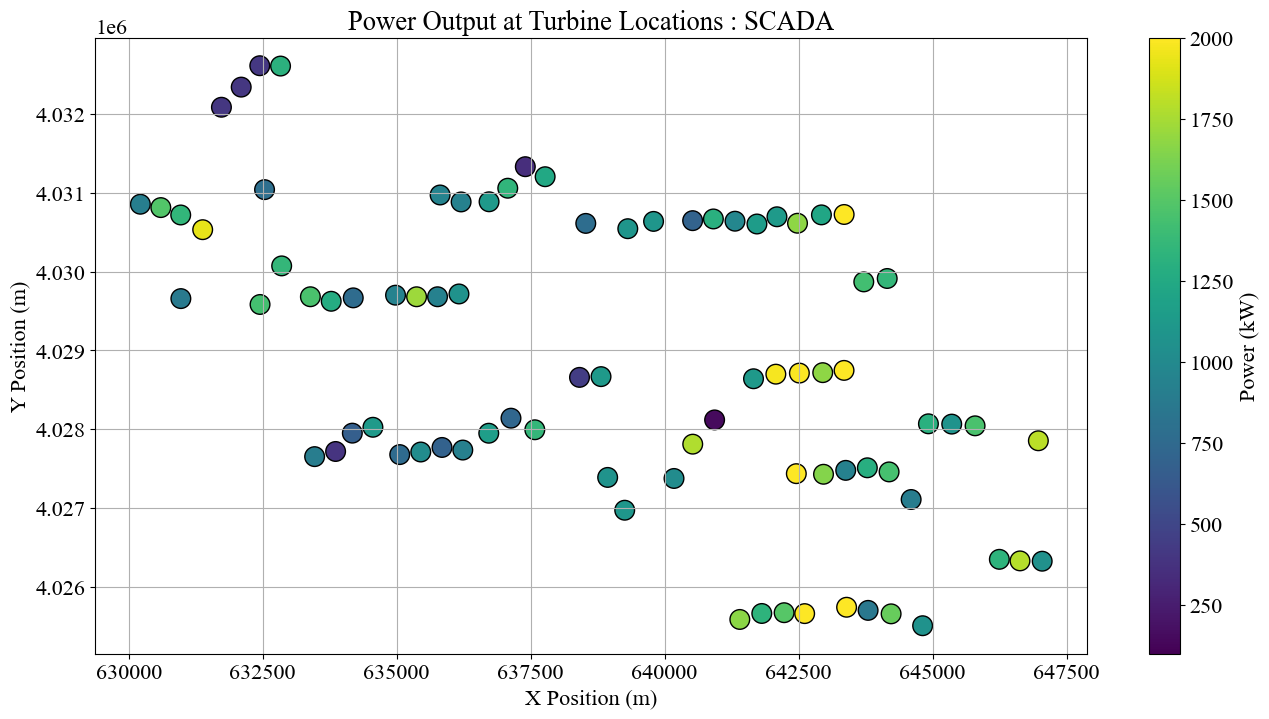

In [5]:

import xarray as xr

SCADAdata = xr.open_dataset(BASE_DIR/"KingPlainsData/KP_SCADA_phase3.nc")



time_of_interest = np.datetime64('2023-08-24T17:00:00')

power_at_time = SCADAdata['Power'].sel(time=time_of_interest,method='nearest')

plt.figure(figsize=(16, 8))
scatter = plt.scatter(layout_x[0:88],layout_y[0:88], c=power_at_time, cmap='viridis', s=200, edgecolors='k', vmin=100, vmax=2000)

# Add a colorbar
plt.colorbar(scatter, label='Power (kW)')

# Add titles and labels
plt.title('Power Output at Turbine Locations : SCADA')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()



In [6]:
k_w_conventional = 0.075

u_mean = 7.4
wd_mean = 230
ti_mean = (12.6)

k_w_TI = 0.41 * ti_mean/100
Jensen_Cases = {
    "Case_1": {
        "k_w": k_w_conventional,
        "turbine_power": [],
        "turbine_velocity": [],
        "total_power": []
    },
    "Case_2": {
        "k_w": k_w_TI,
        "turbine_power": [],
        "turbine_velocity": [],
        "total_power": []
    }
}


In [7]:
import yaml
import numpy as np
import os

# Path to base turbine YAML
base_turbine_yaml = BASE_DIR/"floris-main/floris/turbine_library/iea_10MW.yaml"
turbine_library_path = BASE_DIR/"KingPlainsData/turbine_library"
os.makedirs(turbine_library_path, exist_ok=True)
turbine_names = []

ws = np.arange(0, 26, 1)  # 0–25 m/s in 1 m/s steps

for i in range(N):
    # Load base YAML
    with open(base_turbine_yaml) as f:
        tdict = yaml.safe_load(f)
    
    # Overwrite the values you want
    tdict["turbine_type"] = f"Turbine_{i}"
    tdict["hub_height"] = float(zh)
    tdict["rotor_diameter"] = float(D.iloc[i])
    tdict["multi_dimensional_cp_ct"] = False  # constant CP/CT
    
    # Overwrite power_thrust_table
    tdict["power_thrust_table"]["wind_speed"] = ws.tolist()
    tdict["power_thrust_table"]["power"] = (0.5 * rho * (np.pi * D.iloc[i]**2 / 4000000) * CP.iloc[i] * ws**3).tolist()
    tdict["power_thrust_table"]["thrust_coefficient"] =np.full(len(ws), CT.iloc[i]).tolist()

    # Save to new YAML
    yaml_path = os.path.join(turbine_library_path, f"Turbine_{i}.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(tdict, f, sort_keys=False)

    turbine_names.append(f"Turbine_{i}")


In [8]:
SCADAdata['Yaw'] = SCADAdata['Yaw'].rename(
    {"__resample_dim__": "time"}
)


In [9]:
yaw_angles = (
    SCADAdata['Yaw']
    .sel(time=time_of_interest, method='nearest')
    .values          # convert to numpy
)
yaw_angles = yaw_angles[np.newaxis, :]  # shape (1, 88)

print(np.shape(yaw_angles))



(1, 88)


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


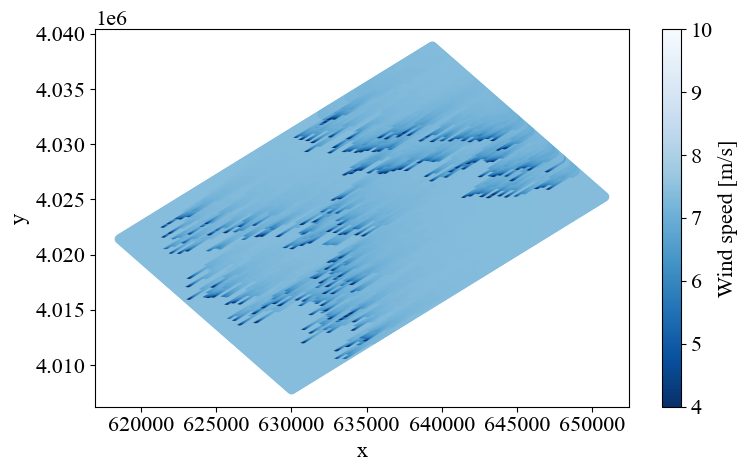

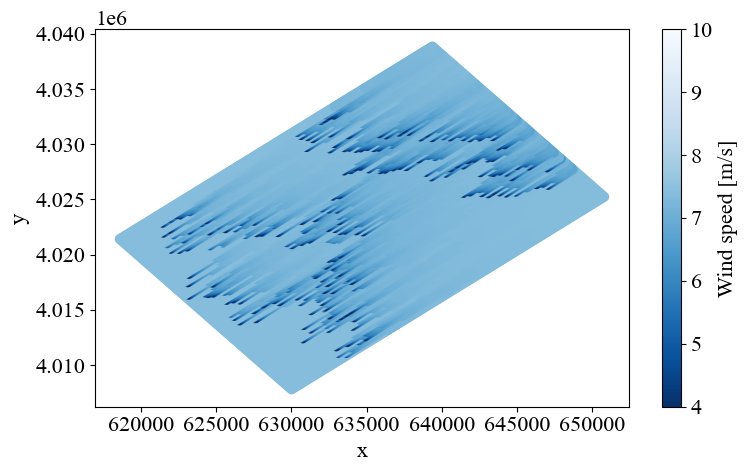

In [10]:




# 2️⃣ Load base FLORIS model
fmodel = FlorisModel(BASE_DIR/"floris-main/examples/inputs/jensen.yaml")

# 3️⃣ Set turbine library path **before calling set()**
fmodel.set(turbine_library_path = turbine_library_path)

# 4️⃣ Set layout and assign turbine types
fmodel.set(
    layout_x=layout_x,
    layout_y=layout_y,
    turbine_type=turbine_names
)




# 5️⃣ Set wind conditions, etc.
fmodel.set(
    wind_speeds=[u_mean],
    wind_directions=[wd_mean],
    turbulence_intensities=[ti_mean/100],
)
# Now you can run your cases
for name, k_w in Jensen_Cases.items():

    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = Jensen_Cases[name]['k_w']
    fmodel.run()
    Jensen_Cases[name]['total_power'] =fmodel.get_farm_power().item()
    Jensen_Cases[name]['turbine_power'] =fmodel.get_turbine_powers().flatten()

    horizontal_plane = fmodel.calculate_horizontal_plane(
        x_resolution=200,
        y_resolution=100,
        height=90.0,
    )

    x = horizontal_plane.df.x1.values
    y = horizontal_plane.df.x2.values
    u = horizontal_plane.df.u.values



    # Plot the wind speed using pcolormesh
    fig, ax = plt.subplots(figsize=(8, 5))
    # Scatter plot with wind speed data
    sc = ax.scatter(x , y, c=u, cmap="Blues_r", vmin=4, vmax=9)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Wind speed [m/s]")
    sc.set_clim(4, 10)


    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.tight_layout()





[1257.7474426  1260.56070078 1270.79620063 1262.58162227 1277.81433579
 1264.08109559 1262.89558378 1266.09553527 1275.09210638 1258.38812688
 1255.39797977 1027.47579387  821.66025244 1015.18452939  995.13024787
  432.40413665  341.02691092 1095.60772763  994.94622444 1109.95475789
 1257.9746971  1014.01516755  909.73737944  970.86979964  811.35557649
  355.68120318  941.2766886  1155.73579453  458.87562039 1121.27510416
 1082.63656565 1053.19632714  762.68278466 1235.14692816 1238.07527552
 1049.20353042 1117.7601007  1114.9044178  1140.85609296 1197.81683308
 1207.04276933 1187.72764059  896.51122654  939.64143334  572.6208885
  684.76056964 1254.5682146  1256.93118813 1260.97704082  694.6003849
 1103.79141291  865.55602857 1146.05487788 1254.78984542 1256.35657073
 1140.13980728 1029.63293483 1023.09146113 1036.4251907  1275.54568655
 1278.67956924 1281.11689485 1249.18473527 1257.18197396 1254.62541516
 1254.95783172 1261.71056138  973.69248716 1262.78357371 1270.9528151
 1275.946

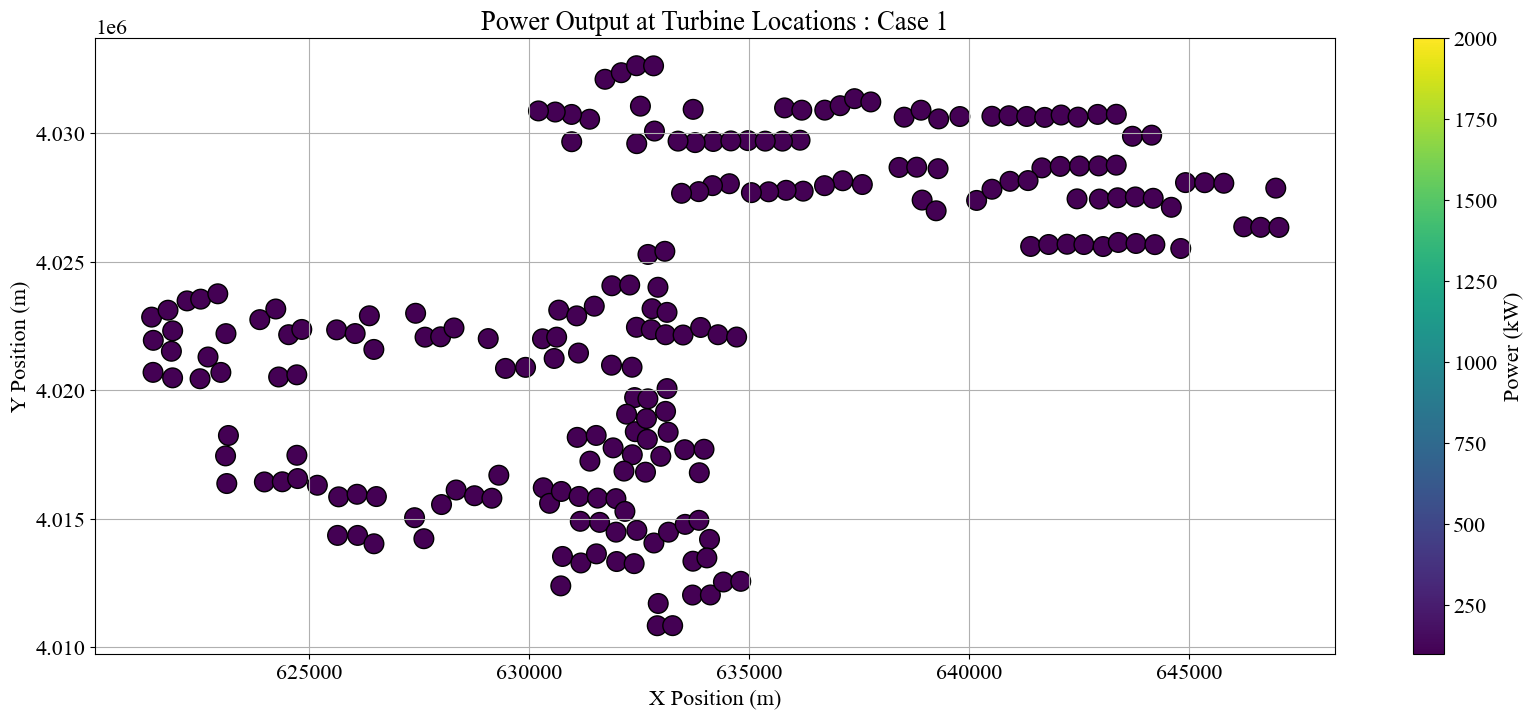

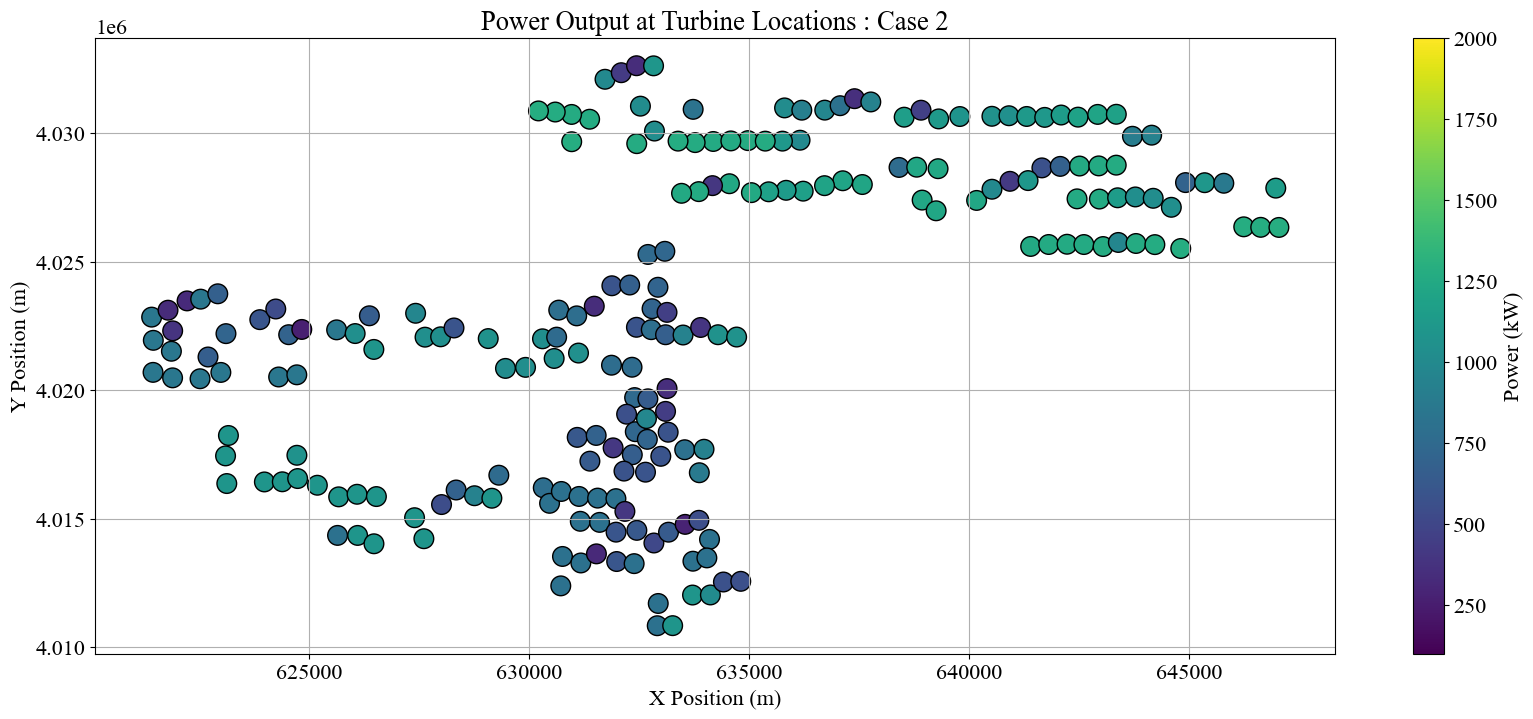

In [11]:

print(Jensen_Cases['Case_1']['turbine_power'])

# Create a scatter plot : ALC : u
plt.figure(figsize=(20, 8))
scatter = plt.scatter(layout_x,layout_y, c=Jensen_Cases['Case_1']['turbine_power']/1000, cmap='viridis', s=200, edgecolors='k', vmin=100, vmax=2000)

# Add a colorbar
plt.colorbar(scatter, label='Power (kW)')

# Add titles and labels
plt.title('Power Output at Turbine Locations : Case 1')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()




# Create a scatter plot : ALC : u
plt.figure(figsize=(20, 8))
scatter = plt.scatter(layout_x,layout_y, c=Jensen_Cases['Case_2']['turbine_power'], cmap='viridis', s=200, edgecolors='k', vmin=100, vmax=2000)

# Add a colorbar
plt.colorbar(scatter, label='Power (kW)')

# Add titles and labels
plt.title('Power Output at Turbine Locations : Case 2')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()




## Calibration

In [12]:
import numpy as np

def jensen_calibration_objective(
    k_w,
    fmodel,
    scada_power,   # shape (88,)
    scada_ws,
    scada_wd,
    scada_ti,
    turbine_ids=None,  # optional explicit mapping
):
    """
    RMSE between SCADA turbine power and FLORIS turbine power
    """

    # --- Update Jensen parameter
    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = float(k_w)

    # --- Set inflow
    fmodel.set(
        wind_speeds=[scada_ws],
        wind_directions=[scada_wd],
        turbulence_intensities=[scada_ti]
    )

    fmodel.run()

    # --- Get turbine powers (numpy!)
    p_model = fmodel.get_turbine_powers()
    # p_model shape: (n_turbines,)
    p_model = p_model[0, :]
    # --- Select turbines
    if turbine_ids is None:
        p_model = p_model[:len(scada_power)]
    else:
        p_model = p_model[turbine_ids]

    scada_power = np.asarray(scada_power)
    diff = p_model - scada_power
    diff = diff[~np.isnan(diff)]
    # --- RMSE
    rmse = np.sqrt(np.mean((diff) ** 2))
    return rmse


rmse_case1 = jensen_calibration_objective(
    Jensen_Cases['Case_1']['k_w'],
    fmodel,
    power_at_time,
    u_mean, wd_mean, ti_mean/100
)

rmse_case2 = jensen_calibration_objective(
    Jensen_Cases['Case_2']['k_w'],
    fmodel,
    power_at_time,
    u_mean, wd_mean, ti_mean/100
)


In [13]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(
    jensen_calibration_objective,
    bounds=(0, 0.12),
    method="bounded",
    args=(fmodel, power_at_time, u_mean, wd_mean, ti_mean/100)
)



In [14]:
print(f"Case 1 RMSE: {rmse_case1}")
print(f"Case 2 RMSE: {rmse_case2}")
print(f"Case 3 RMSE: {res.fun}")
print("k_w case 1:", Jensen_Cases['Case_1']['k_w'])
print("k_w case 2:", Jensen_Cases['Case_2']['k_w'])
print("k_w case 3:", res.x)

Jensen_Cases['Case_3']={}
Jensen_Cases['Case_3']['k_w'] = res.x


Case 1 RMSE: 409.7990707986782
Case 2 RMSE: 425.0019580927716
Case 3 RMSE: 408.68925394125716
k_w case 1: 0.075
k_w case 2: 0.05166
k_w case 3: 0.07480827619127808


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


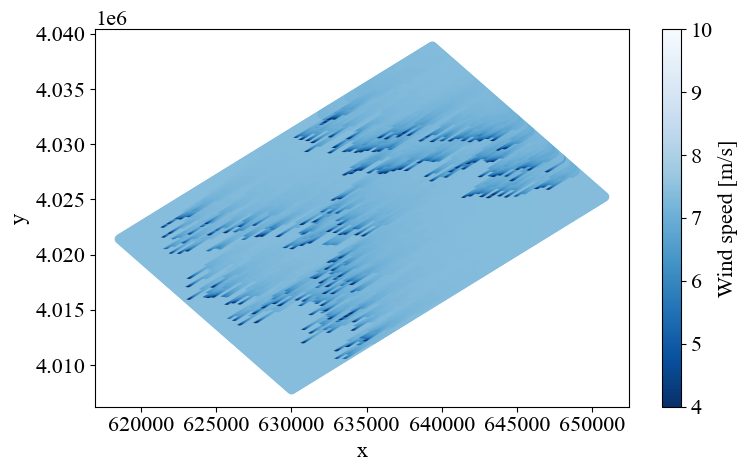

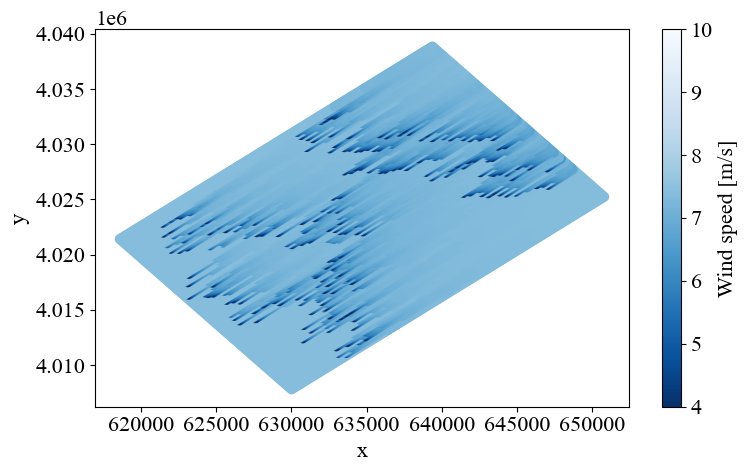

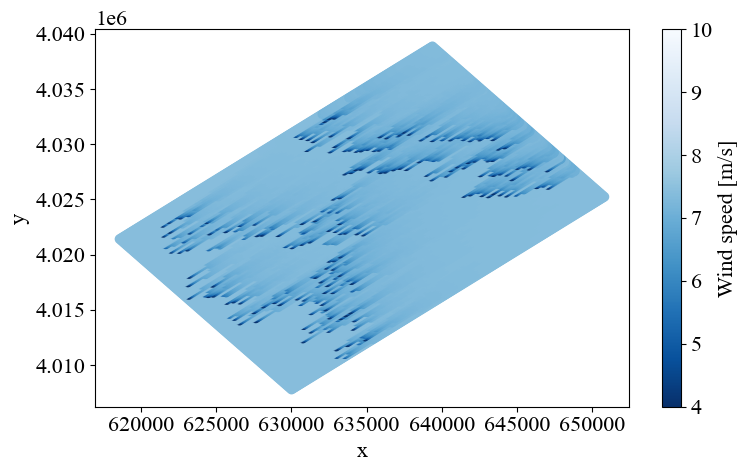

In [15]:




# 2️⃣ Load base FLORIS model
fmodel = FlorisModel(BASE_DIR/"floris-main/examples/inputs/jensen.yaml")

# 3️⃣ Set turbine library path **before calling set()**
fmodel.set(turbine_library_path = turbine_library_path)

# 4️⃣ Set layout and assign turbine types
fmodel.set(
    layout_x=layout_x,
    layout_y=layout_y,
    turbine_type=turbine_names
)

# 5️⃣ Set wind conditions, etc.
fmodel.set(
    wind_speeds=[u_mean],
    wind_directions=[wd_mean],
    turbulence_intensities=[ti_mean/100]
)
# Now you can run your cases
for name, k_w in Jensen_Cases.items():

    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = Jensen_Cases[name]['k_w']
    fmodel.run()
    Jensen_Cases[name]['total_power'] =fmodel.get_farm_power().item()
    Jensen_Cases[name]['turbine_power'] =fmodel.get_turbine_powers().flatten()

    horizontal_plane = fmodel.calculate_horizontal_plane(
        x_resolution=200,
        y_resolution=100,
        height=90.0,
    )

    x = horizontal_plane.df.x1.values
    y = horizontal_plane.df.x2.values
    u = horizontal_plane.df.u.values



    # Plot the wind speed using pcolormesh
    fig, ax = plt.subplots(figsize=(8, 5))
    # Scatter plot with wind speed data
    sc = ax.scatter(x , y, c=u, cmap="Blues_r", vmin=4, vmax=9)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Wind speed [m/s]")
    sc.set_clim(4, 10)


    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.tight_layout()





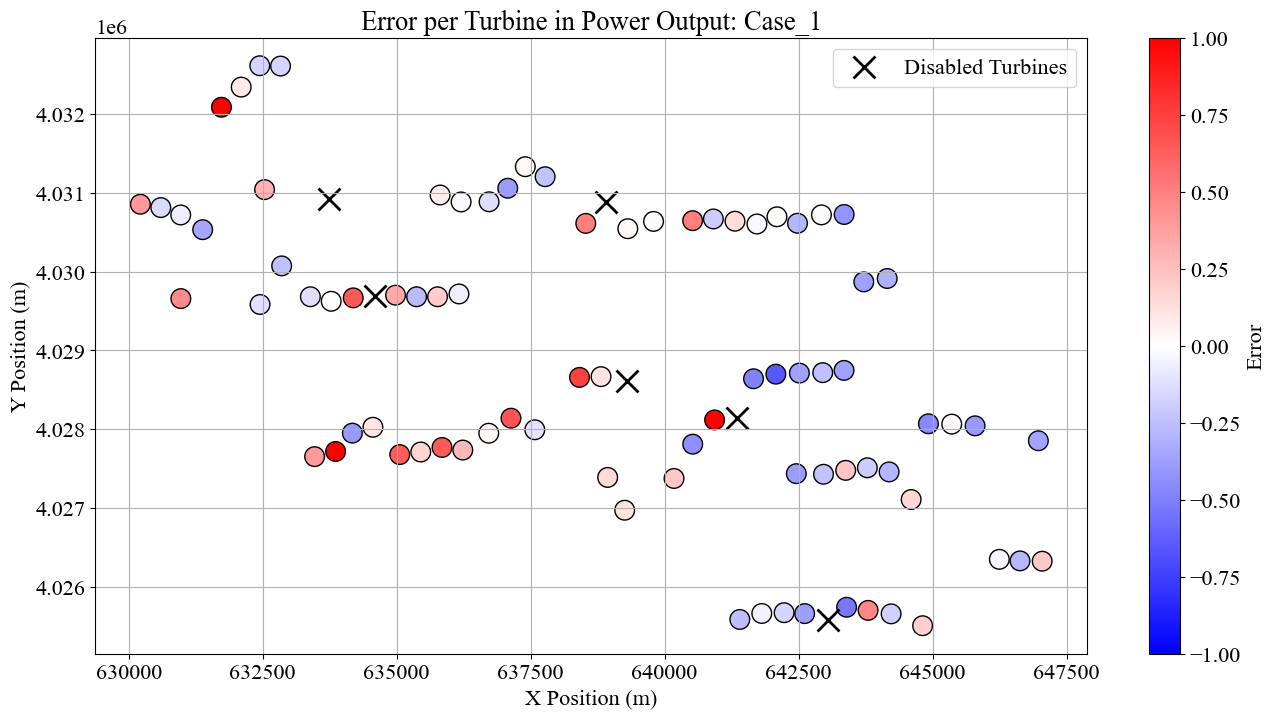

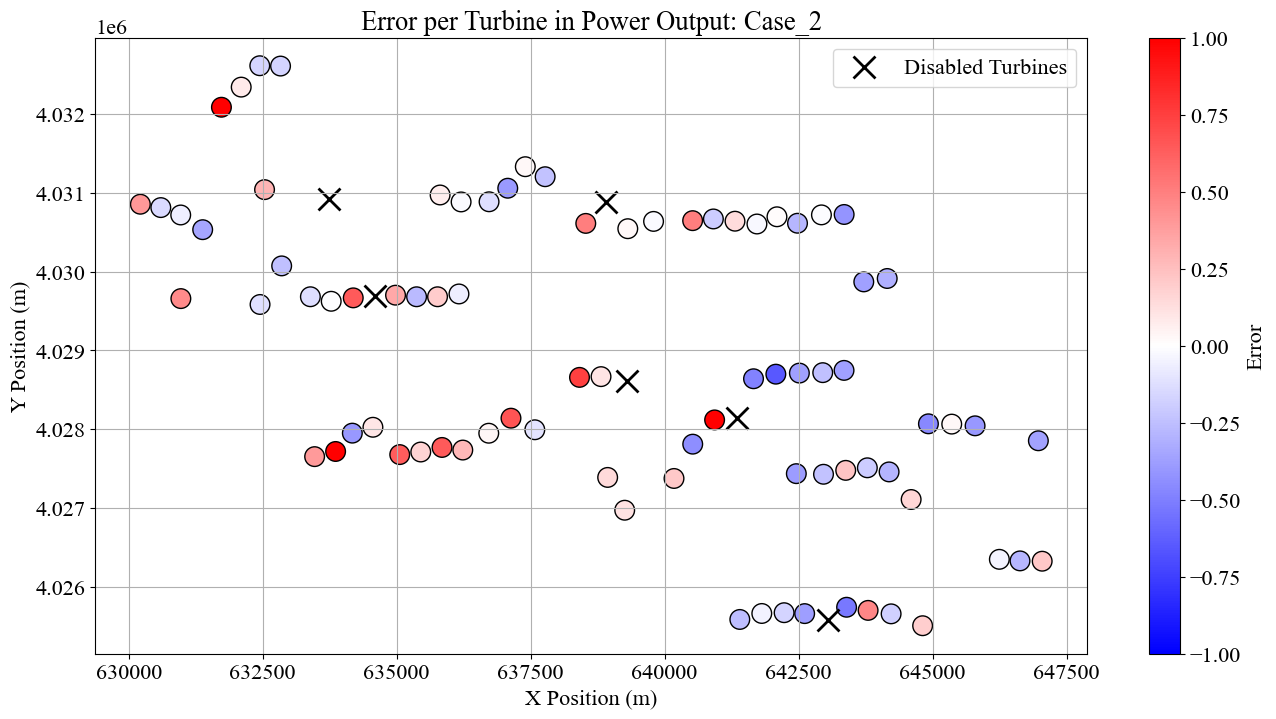

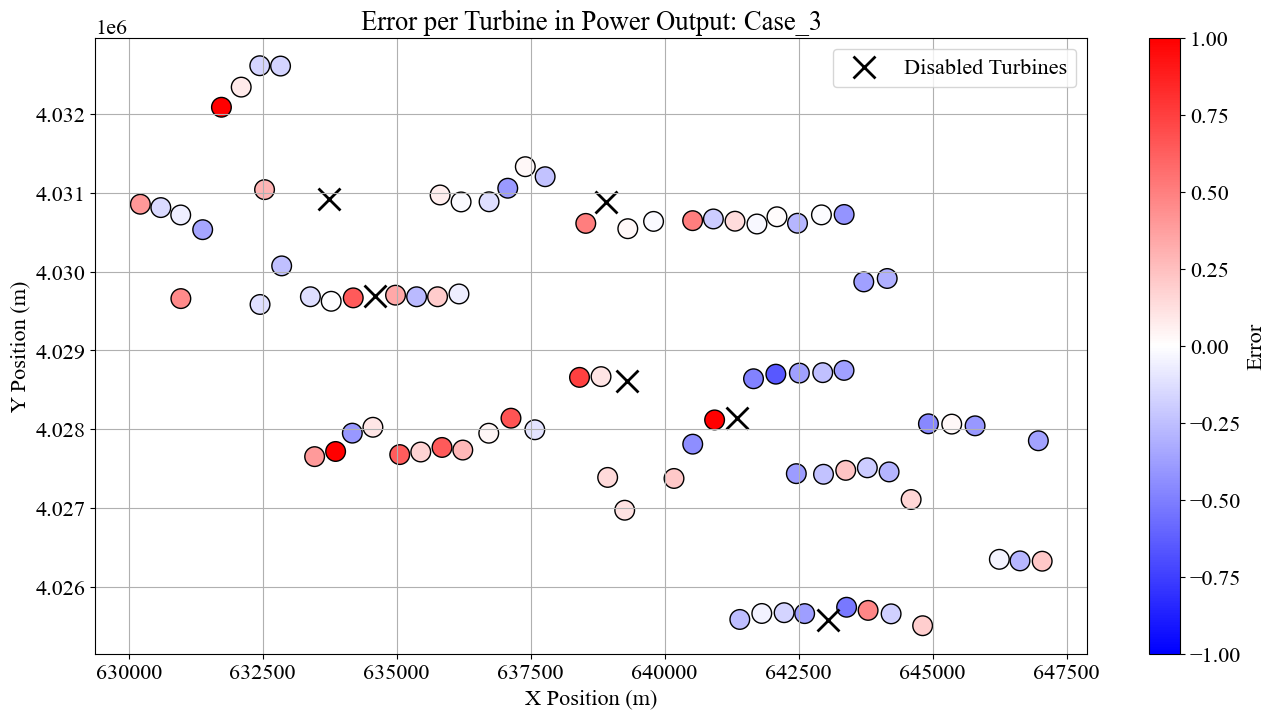

In [16]:
    
for name, k_w in Jensen_Cases.items():
    plt.figure(figsize=(16, 8))


    lx = np.array(layout_x.iloc[:88])
    ly = np.array(layout_y.iloc[:88])
    zero_mask =  (power_at_time == 0) | np.isnan(power_at_time)
    nonzero_mask = ~zero_mask

    # Compute error safely
    error = (
        Jensen_Cases[name]['turbine_power'][:88]
        - power_at_time
    ) / power_at_time

    sc = plt.scatter(
        lx[nonzero_mask],
        ly[nonzero_mask],
        c=error[nonzero_mask],
        cmap='bwr',
        s=200,
        edgecolors='k',
        vmin=-1,
        vmax=1
    )

    plt.scatter(
        lx[zero_mask],
        ly[zero_mask],
        marker='x',
        c='k',
        s=250,
        linewidths=2,
        label='Disabled Turbines'
    )


    # Colorbar
    plt.colorbar(sc, label='Error')

    # Labels and formatting
    plt.title(f'Error per Turbine in Power Output: {name}')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()
    plt.show()


# Stable Case

In [17]:
k_w_conventional = 0.075
u_mean= 8.7
wd_mean = 132
ti_mean = 1
k_w_TI = 0.41 * ti_mean /100

Jensen_Cases = {
    "Case_1": {
        "k_w": k_w_conventional,
        "turbine_power": [],
        "turbine_velocity": [],
        "total_power": []
    },
    "Case_2": {
        "k_w": k_w_TI,
        "turbine_power": [],
        "turbine_velocity": [],
        "total_power": []
    }
}


In [18]:
import yaml
import numpy as np
import os

# Path to base turbine YAML
base_turbine_yaml = BASE_DIR/"floris-main/floris/turbine_library/iea_10MW.yaml"
turbine_library_path = BASE_DIR/"KingPlainsData/turbine_library"
os.makedirs(turbine_library_path, exist_ok=True)
turbine_names = []

ws = np.array([0, 4, 8, 12, 25], dtype=float)  # wind speeds

for i in range(N):
    # Load base YAML
    with open(base_turbine_yaml) as f:
        tdict = yaml.safe_load(f)
    
    # Overwrite the values you want
    tdict["turbine_type"] = f"Turbine_{i}"
    tdict["hub_height"] = float(zh)
    tdict["rotor_diameter"] = float(D.iloc[i])
    tdict["multi_dimensional_cp_ct"] = False  # constant CP/CT
    
    # Overwrite power_thrust_table
    tdict["power_thrust_table"]["wind_speed"] = ws.tolist()
    tdict["power_thrust_table"]["power"] = (0.5 * rho * (np.pi * D.iloc[i]**2 / 4000000) * CP.iloc[i] * ws**3).tolist()
    tdict["power_thrust_table"]["thrust_coefficient"] =np.full(len(ws), CT.iloc[i]).tolist()

    # Save to new YAML
    yaml_path = os.path.join(turbine_library_path, f"Turbine_{i}.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(tdict, f, sort_keys=False)

    turbine_names.append(f"Turbine_{i}")


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


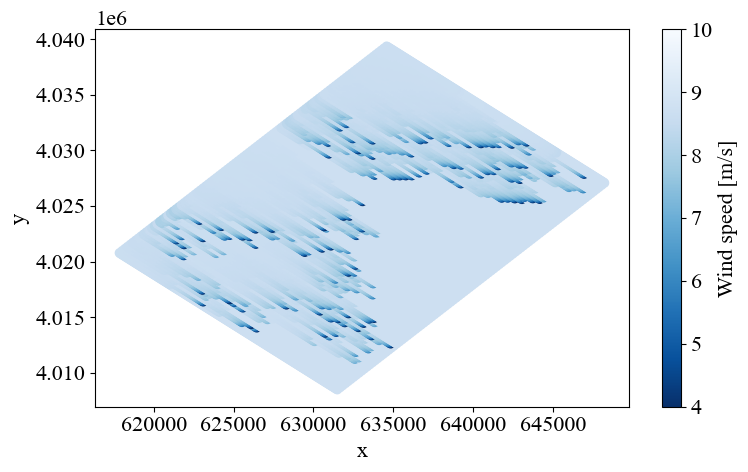

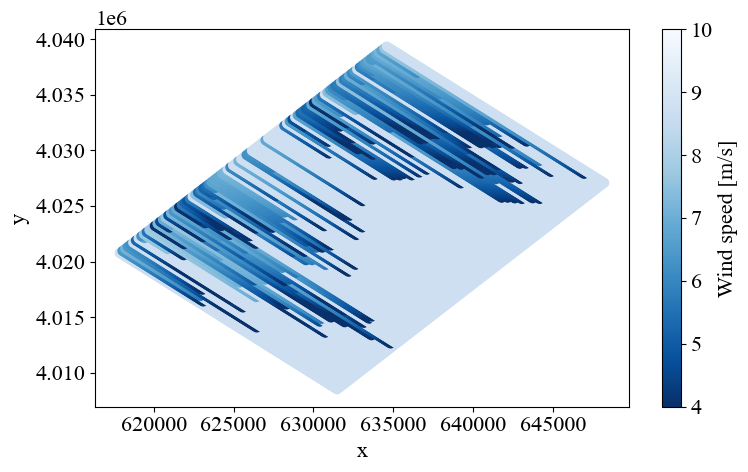

In [19]:




# 2️⃣ Load base FLORIS model
fmodel = FlorisModel(BASE_DIR/"floris-main/examples/inputs/jensen.yaml")

# 3️⃣ Set turbine library path **before calling set()**
fmodel.set(turbine_library_path = turbine_library_path)

# 4️⃣ Set layout and assign turbine types
fmodel.set(
    layout_x=layout_x,
    layout_y=layout_y,
    turbine_type=turbine_names
)

# 5️⃣ Set wind conditions, etc.
fmodel.set(
    wind_speeds=[u_mean],
    wind_directions=[wd_mean],
    turbulence_intensities=[ti_mean/100]
)
# Now you can run your cases
for name, k_w in Jensen_Cases.items():

    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = Jensen_Cases[name]['k_w']
    fmodel.run()
    Jensen_Cases[name]['total_power'] =fmodel.get_farm_power().item()
    Jensen_Cases[name]['turbine_power'] =fmodel.get_turbine_powers().flatten()

    horizontal_plane = fmodel.calculate_horizontal_plane(
        x_resolution=200,
        y_resolution=100,
        height=90.0,
    )

    x = horizontal_plane.df.x1.values
    y = horizontal_plane.df.x2.values
    u = horizontal_plane.df.u.values



    # Plot the wind speed using pcolormesh
    fig, ax = plt.subplots(figsize=(8, 5))
    # Scatter plot with wind speed data
    sc = ax.scatter(x , y, c=u, cmap="Blues_r", vmin=4, vmax=9)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Wind speed [m/s]")
    sc.set_clim(4, 10)


    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.tight_layout()




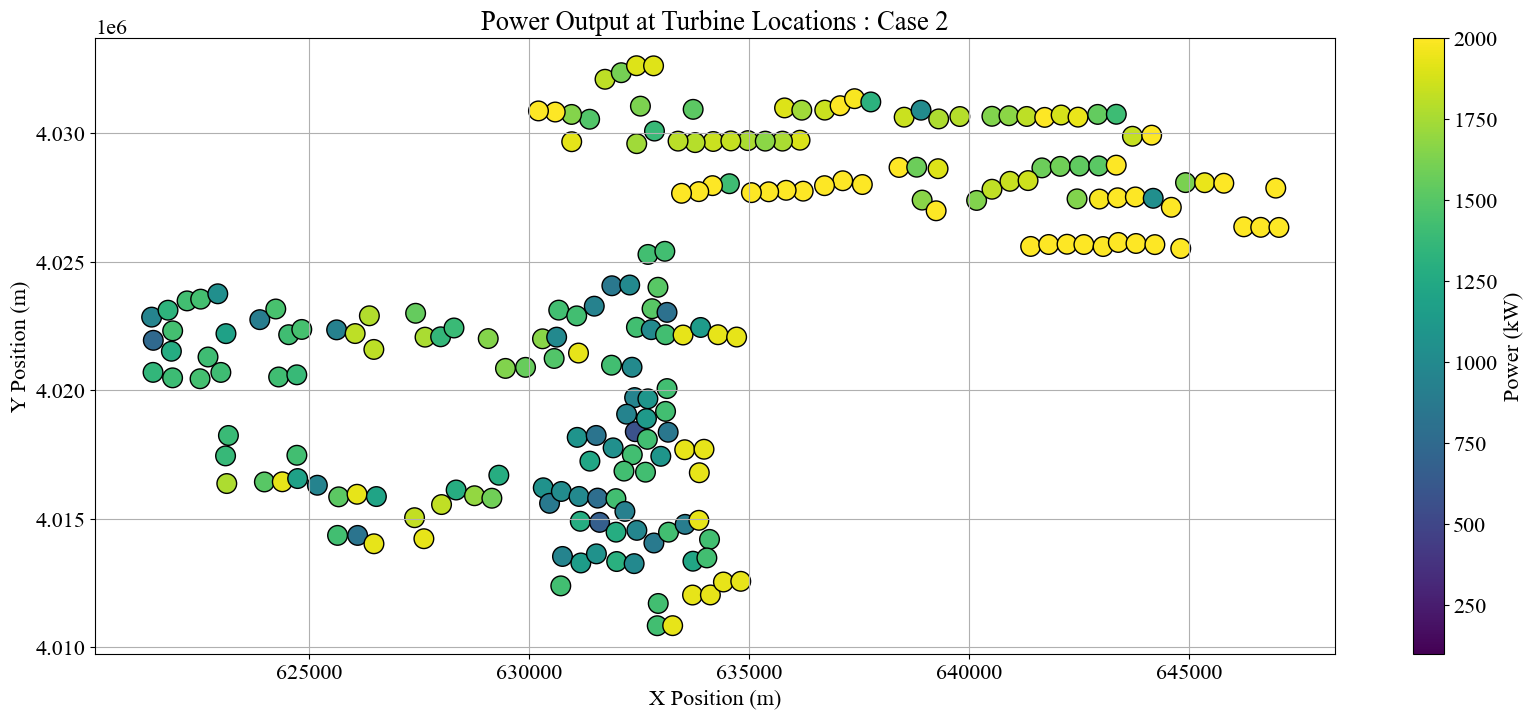

In [20]:





# Create a scatter plot : ALC : u
plt.figure(figsize=(20, 8))
scatter = plt.scatter(layout_x,layout_y, c=Jensen_Cases['Case_2']['turbine_power'], cmap='viridis', s=200, edgecolors='k', vmin=100, vmax=2000)

# Add a colorbar
plt.colorbar(scatter, label='Power (kW)')

# Add titles and labels
plt.title('Power Output at Turbine Locations : Case 2')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()




## Comparison with SCADA

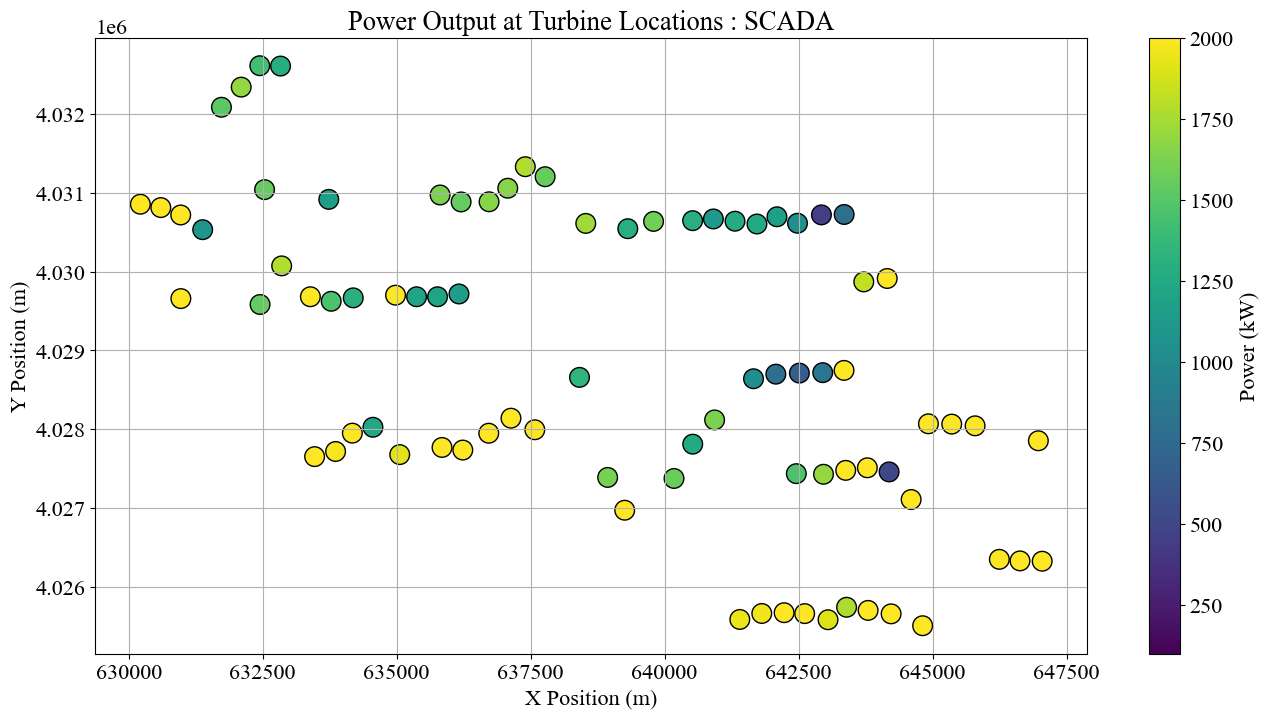

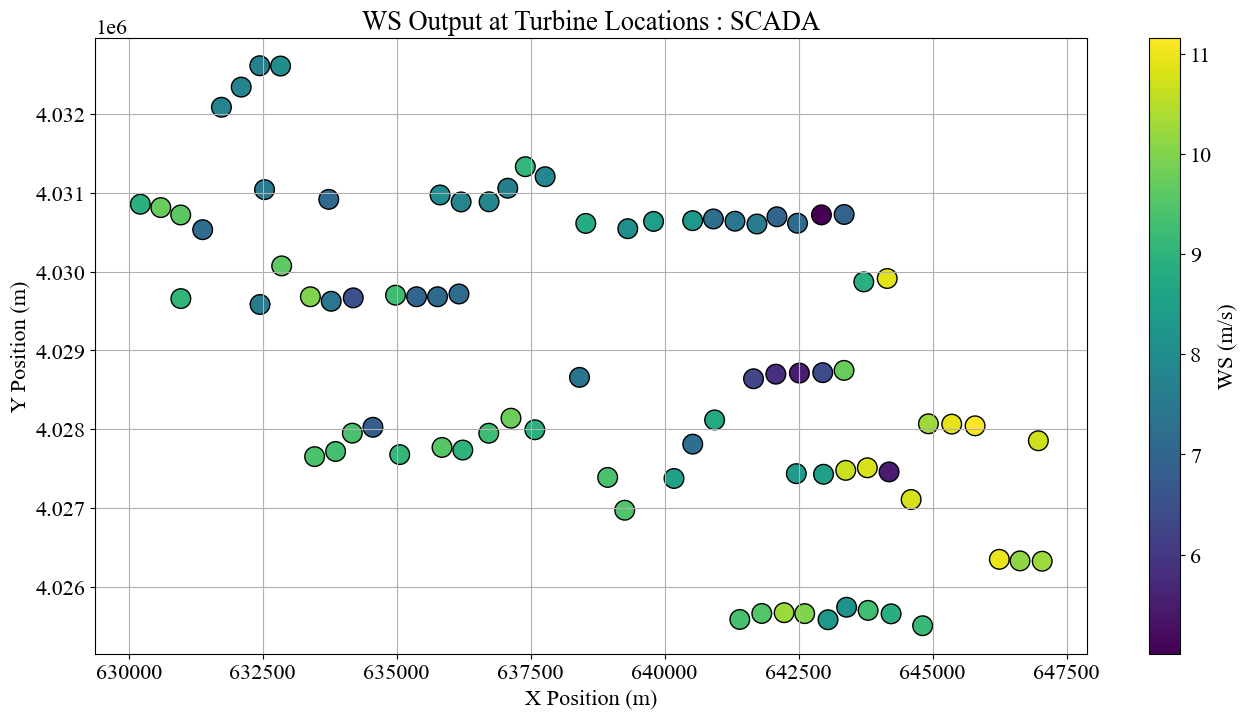

In [21]:

import xarray as xr

SCADAdata = xr.open_dataset(BASE_DIR/"KingPlainsData/KP_SCADA_phase3.nc")
time_of_interest = np.datetime64('2023-08-24T03:00:00')


power_at_time = SCADAdata['Power'].sel(time=time_of_interest,method='nearest')

plt.figure(figsize=(16, 8))
scatter = plt.scatter(layout_x[0:88],layout_y[0:88], c=power_at_time, cmap='viridis', s=200, edgecolors='k', vmin=100, vmax=2000)

# Add a colorbar
plt.colorbar(scatter, label='Power (kW)')

# Add titles and labels
plt.title('Power Output at Turbine Locations : SCADA')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

ws_at_time = SCADAdata['Wind Speed'].sel(time=time_of_interest,method='nearest')

plt.figure(figsize=(16, 8))
scatter = plt.scatter(layout_x[0:88],layout_y[0:88], c=ws_at_time, cmap='viridis', s=200, edgecolors='k')

# Add a colorbar
plt.colorbar(scatter, label='WS (m/s)')

# Add titles and labels
plt.title('WS Output at Turbine Locations : SCADA')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()



## Calibration

In [22]:
import numpy as np

def jensen_calibration_objective(
    k_w,
    fmodel,
    scada_power,   # shape (88,)
    scada_ws,
    scada_wd,
    scada_ti,
    turbine_ids=None,  # optional explicit mapping
):
    """
    RMSE between SCADA turbine power and FLORIS turbine power
    """

    # --- Update Jensen parameter
    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = float(k_w)

    # --- Set inflow
    fmodel.set(
        wind_speeds=[scada_ws],
        wind_directions=[scada_wd],
        turbulence_intensities=[scada_ti]
    )

    fmodel.run()

    
    # --- Get turbine powers (numpy!)
    p_model = fmodel.get_turbine_powers()
    # p_model shape: (n_turbines,)
    p_model = p_model[0, :]
    # --- Select turbines
    if turbine_ids is None:
        p_model = p_model[:len(scada_power)]
    else:
        p_model = p_model[turbine_ids]

    scada_power = np.asarray(scada_power)
    diff = p_model - scada_power
    diff = diff[~np.isnan(diff)]
    # --- RMSE
    rmse = np.sqrt(np.mean((diff) ** 2))
    return rmse


rmse_case1 = jensen_calibration_objective(
    Jensen_Cases['Case_1']['k_w'],
    fmodel,
    power_at_time,
    u_mean,wd_mean,ti_mean/100
)

rmse_case2 = jensen_calibration_objective(
    Jensen_Cases['Case_2']['k_w'],
    fmodel,
    power_at_time,
    u_mean,wd_mean,ti_mean/100
)


In [23]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(
    jensen_calibration_objective,
    bounds=(0, 0.12),
    method="bounded",
    args=(fmodel, power_at_time,u_mean,wd_mean,ti_mean/100)
)



In [24]:
print(f"Case 1 RMSE: {rmse_case1}")
print(f"Case 2 RMSE: {rmse_case2}")
print(f"Case 3 RMSE: {res.fun}")
print("k_w case 1:", Jensen_Cases['Case_1']['k_w'])
print("k_w case 2:", Jensen_Cases['Case_2']['k_w'])
print("k_w case 3:", res.x)

Jensen_Cases['Case_3']={}
Jensen_Cases['Case_3']['k_w'] = res.x

Case 1 RMSE: 494.34272003783235
Case 2 RMSE: 514.9289258791383
Case 3 RMSE: 309.7013835592421
k_w case 1: 0.075
k_w case 2: 0.0040999999999999995
k_w case 3: 0.01862814060825056


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


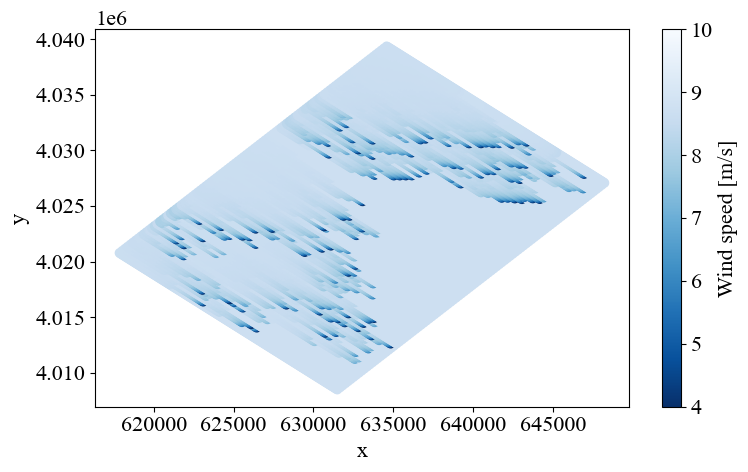

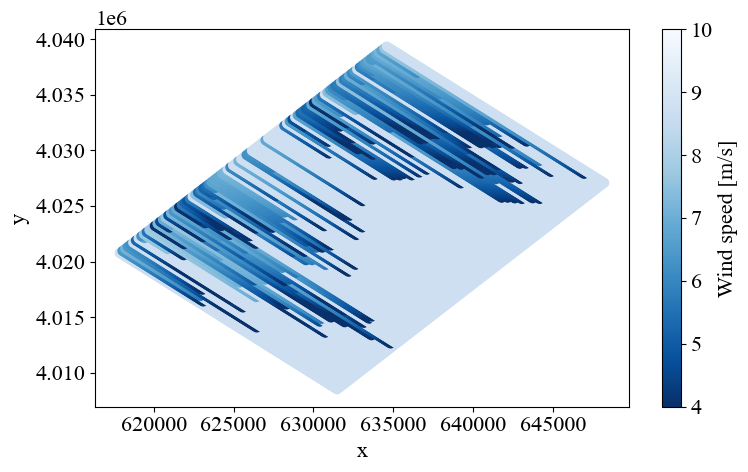

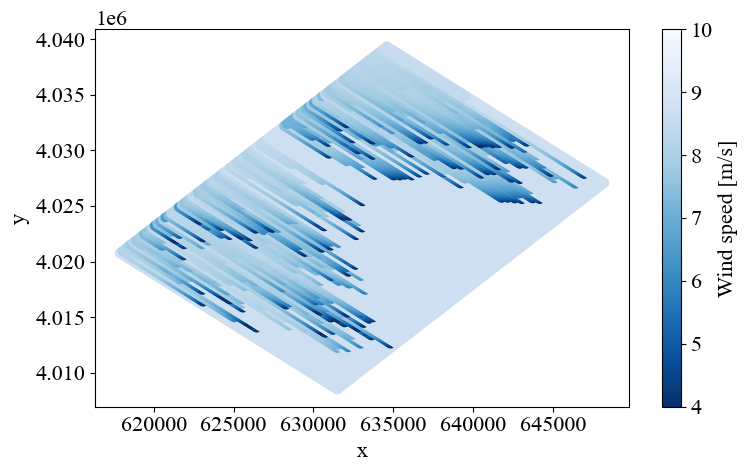

In [25]:




# 2️⃣ Load base FLORIS model
fmodel = FlorisModel(BASE_DIR/"floris-main/examples/inputs/jensen.yaml")

# 3️⃣ Set turbine library path **before calling set()**
fmodel.set(turbine_library_path = turbine_library_path)

# 4️⃣ Set layout and assign turbine types
fmodel.set(
    layout_x=layout_x,
    layout_y=layout_y,
    turbine_type=turbine_names
)

# 5️⃣ Set wind conditions, etc.
fmodel.set(
    wind_speeds=[u_mean],
    wind_directions=[wd_mean],
    turbulence_intensities=[ti_mean/100]
)
# Now you can run your cases
for name, k_w in Jensen_Cases.items():

    fmodel.core.wake.wake_velocity_parameters["jensen"]["we"] = Jensen_Cases[name]['k_w']
    fmodel.run()
    Jensen_Cases[name]['total_power'] =fmodel.get_farm_power().item()
    Jensen_Cases[name]['turbine_power'] =fmodel.get_turbine_powers().flatten()

    horizontal_plane = fmodel.calculate_horizontal_plane(
        x_resolution=200,
        y_resolution=100,
        height=90.0,
    )

    x = horizontal_plane.df.x1.values
    y = horizontal_plane.df.x2.values
    u = horizontal_plane.df.u.values



    # Plot the wind speed using pcolormesh
    fig, ax = plt.subplots(figsize=(8, 5))
    # Scatter plot with wind speed data
    sc = ax.scatter(x , y, c=u, cmap="Blues_r", vmin=4, vmax=9)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Wind speed [m/s]")
    sc.set_clim(4, 10)


    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.tight_layout()





In [26]:
print(power_at_time)

<xarray.DataArray 'Power' (num_turbines: 88)> Size: 704B
array([1308.123704, 1460.943453, 2146.053027, 1545.459821, 2375.211572,
       1097.019619, 2118.953434, 2037.995823, 2124.759253, 1989.808836,
               nan, 1776.172609, 1146.784742, 1550.5302  , 1510.917456,
       1692.434806, 1425.515236, 1276.119423, 1150.865045, 1211.938814,
       1209.257166, 1621.99601 , 1547.948714, 1655.344745, 1655.632186,
       1774.995156, 1557.216321, 1727.055318,         nan, 1294.13125 ,
       1591.73311 , 1288.659011, 1339.384985,         nan,         nan,
       1130.280762, 1260.92972 , 1243.398065, 1163.232025, 1049.068536,
        454.361683,  795.218197, 1822.18476 , 2420.040841, 1026.080321,
        784.082606,  650.38965 ,  844.142391, 2053.490424, 2242.73822 ,
       2466.485303, 2535.828149, 2562.960282, 1459.176967, 1689.66346 ,
       2170.247949, 2321.176778,  504.179046, 2381.91165 , 2257.318359,
       2230.095125, 2185.168982, 1944.313965, 1960.959359, 2139.661344,
       

In [27]:
print(error)

<xarray.DataArray 'Power' (num_turbines: 88)> Size: 704B
array([ 0.64784383, -0.00607327, -0.12710354, -0.1196124 ,  0.45706888,
       -0.34526376, -0.06739878, -0.14536561,  0.40515515,  0.33900409,
               nan, -0.24438044,         nan,  0.29617514,  1.47792885,
        0.08171161, -0.16678729, -0.1673514 , -0.06561408,  0.19919522,
       -0.26926331,  0.06545759, -0.02223852, -0.13114561, -0.39608891,
        0.02652114, -0.24158994,  0.50373183,         nan,  0.02618886,
       -0.01633843,  0.50254514,  0.74466898,  0.10348533,         nan,
       -0.19871457,  0.13863865, -0.02686592,  0.0135887 , -0.28663469,
       -0.01213382, -0.4214651 , -0.37159254, -0.30912175, -0.48933526,
       -0.65347853, -0.37022941, -0.24936845, -0.37303279, -0.46704084,
        0.02589818, -0.40397058, -0.36439054, -0.3874624 , -0.23862544,
        0.23286671, -0.20051445, -0.29036587,  0.15724034, -0.04044764,
       -0.28424641,  0.21262254, -0.25175899, -0.0542836 , -0.16508747,
       

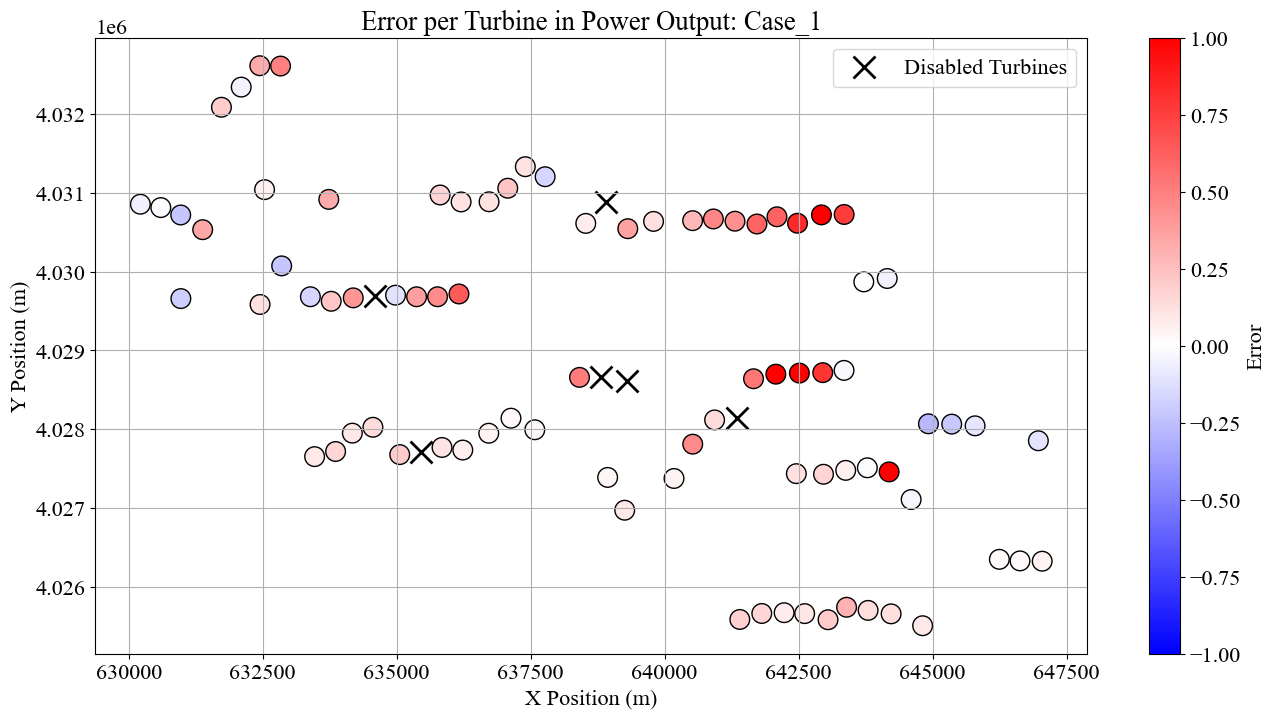

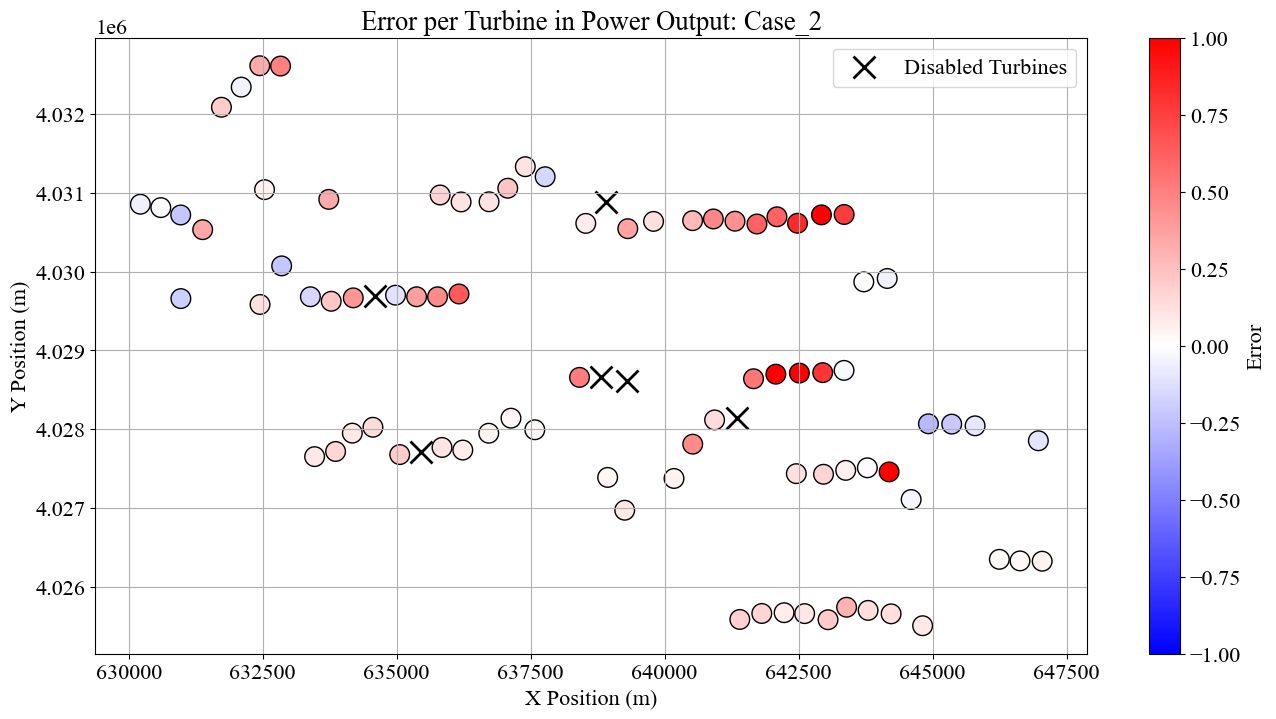

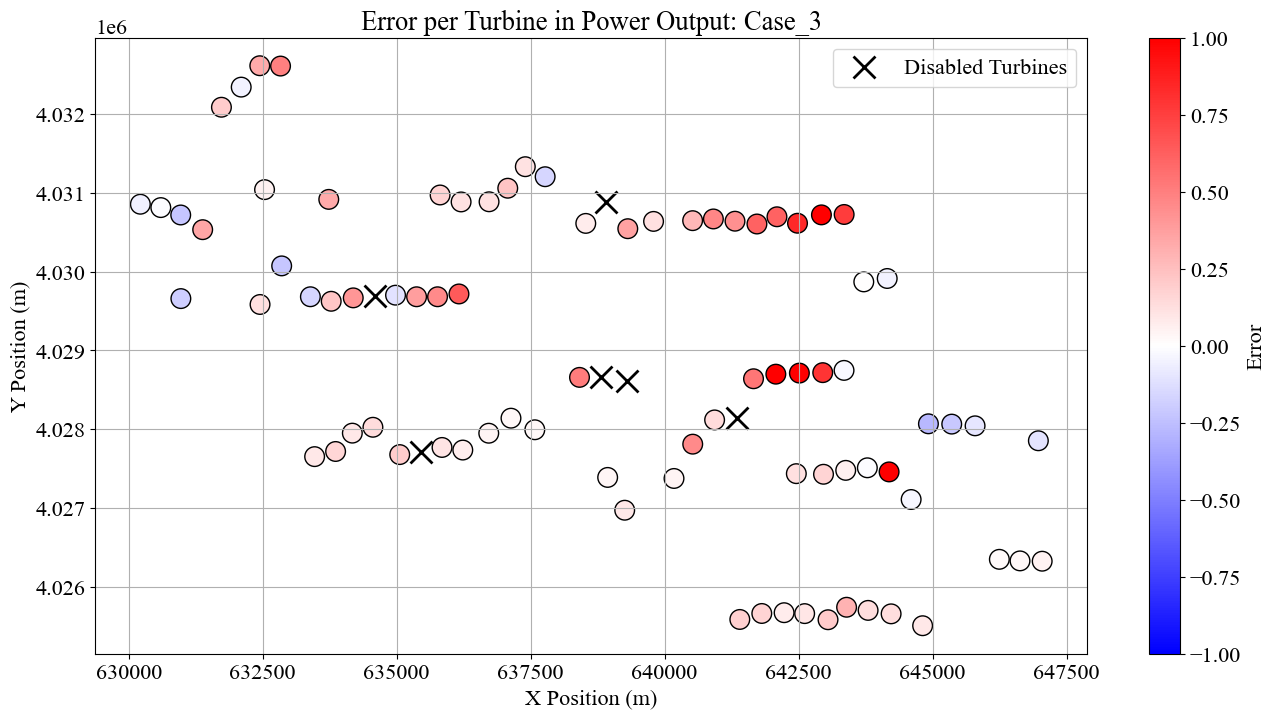

In [28]:
    
for name, k_w in Jensen_Cases.items():
    plt.figure(figsize=(16, 8))


    lx = np.array(layout_x.iloc[:88])
    ly = np.array(layout_y.iloc[:88])
    zero_mask =  (power_at_time == 0) | np.isnan(power_at_time)
    nonzero_mask = ~zero_mask

    # Compute error safely
    error = (
        Jensen_Cases[name]['turbine_power'][:88]
        - power_at_time
    ) / power_at_time

    sc = plt.scatter(
        lx[nonzero_mask],
        ly[nonzero_mask],
        c=error[nonzero_mask],
        cmap='bwr',
        s=200,
        edgecolors='k',
        vmin=-1,
        vmax=1
    )

    plt.scatter(
        lx[zero_mask],
        ly[zero_mask],
        marker='x',
        c='k',
        s=250,
        linewidths=2,
        label='Disabled Turbines'
    )


    # Colorbar
    plt.colorbar(sc, label='Error')

    # Labels and formatting
    plt.title(f'Error per Turbine in Power Output: {name}')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()
    plt.show()
